polar to cartesian
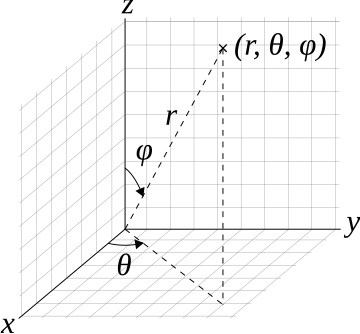

### installs

In [1]:
#check if this colab environment
on_colab = 'google.colab' in str(get_ipython())


In [2]:
import os

In [3]:
if on_colab:
  from google.colab import drive
  drive.mount('/content/drive')

In [4]:
# !wget https://github.com/NVIDIAGameWorks/kaolin/raw/4d8f49dd3e617cb1fec3e2c2bc3b2903ff952321/examples/samples/rendered_clock.zip
# !unzip rendered_clock.zip
if on_colab:
  !git clone https://github.com/NVIDIAGameWorks/kaolin.git
  !pip install kaolin==0.16.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.4.0_cu121.html --quiet
  !pip install torch torchvision transformers diffusers pillow  --quiet
  !pip install objaverse --quiet
  !pip install lpips
  !pip install -U "comet_ml>=3.44.0" --quiet
  !cp /content/kaolin/kaolin/render/lighting/sg.py /usr/local/lib/python3.10/dist-packages/kaolin/render/lighting/sg.py
# !wget https://raw.githubusercontent.com/NVIDIAGameWorks/kaolin/bcbc92f4ed6f176e9d320932ea5ee1262e2ce059/examples/samples/sphere.obj

In [5]:
if on_colab:
  checkpoint_root = '/content/drive/MyDrive/Adver_diff_checkpoints/'
else:
  checkpoint_root = '/home/dcor/niskhizov/adv_diff_checkpoints/'

In [6]:
#@title comet stuff
import comet_ml
from comet_ml.integration.pytorch import watch

comet_ml.login(project_name="Adversarial-diff-rendering-notebook-V3")

In [7]:
from IPython.display import clear_output
clear_output()

### imports

In [8]:
import kaolin
import kaolin as kal
import pickle
import torch
import objaverse


import math
import matplotlib.pyplot as plt

from kaolin.render.lighting import SgLightingParameters
import numpy as np

from datetime import datetime

Warp 1.4.2 initialized:
   CUDA Toolkit 12.6, Driver 12.0
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA RTX A6000" (48 GiB, sm_86, mempool enabled)
   Kernel cache:
     /home/dcor/niskhizov/.cache/warp/1.4.2


###  dynamic light, camera rendering funcs

In [9]:


IMAGE_SIZE = 1024

def make_camera(eye):
  return kal.render.camera.Camera.from_args(eye=torch.tensor(eye),
                                         at=torch.tensor([0., 0., 0.]),
                                         up=torch.tensor([0., 1., 0]),
                                         fov=math.pi * 45 / 180,
                                            near=0.1, far=10000.,
                                         width=IMAGE_SIZE,
                                            height=IMAGE_SIZE,
                                            device='cuda')
forbidden_theta = []
forbidden_phi = []

resolution = 20
for theta in np.linspace(0.0001, 0.6, 3):
    forbidden_theta.append(theta)

for phi in np.linspace(0.0001, 10, resolution):
    forbidden_phi.append(phi)

forbidden_theta = set(forbidden_theta)
forbidden_phi = set(forbidden_phi)

def random_polar(r_range, phi_range, theta_range):
  done = False
  while not done:
    r = np.random.uniform(r_range[0], r_range[1])
    theta = np.random.uniform(theta_range[0], theta_range[1])
    phi = np.random.uniform(phi_range[0], phi_range[1])
    if theta not in forbidden_theta and phi not in forbidden_phi:
      done = True
  return [r, theta, phi]


def polar_to_cartesian(r, phi, theta):
  y = r * math.cos(theta)
  z = r * math.sin(theta) * math.cos(phi)
  x = r * math.sin(theta) * math.sin(phi)
  return [x,y,z]

def random_light(strength_range = [8,15],suns_range=[1, 5], phi_range=[0, math.pi * 2], theta_range=[0, math.pi / 2]):
  n_suns = int(np.random.uniform(suns_range[0],suns_range[1]))
  light_directions = []
  for i in range(n_suns):
    [r, theta, phi] = random_polar(r_range=[1, 5], phi_range=phi_range, theta_range=theta_range)
    direction = np.array(polar_to_cartesian(r, phi, theta))
    direction = direction / np.sqrt(np.sum(direction * direction))
    light_directions.append(direction)

  light_directions = torch.tensor(np.array(light_directions)).cuda()

  strength = np.random.uniform(strength_range[0],strength_range[1])
  lighting = SgLightingParameters.from_sun(light_directions.float(), strength).cuda()

  return lighting, (strength,light_directions)

def polar_camera_and_light(r, phi, theta):
  eye = polar_to_cartesian(r, phi, theta)
  camera = make_camera(eye)
  eye = np.array(eye)
  eye_norm = np.sqrt(np.sum(eye * eye))

  n_suns = int(np.random.uniform(1, 5))
  light_directions = []
  light_direction = torch.tensor(eye / eye_norm, dtype=torch.float32).view(1, 1, 3).cuda()
  strength = np.random.uniform(4, 10)
  lighting = SgLightingParameters.from_sun(light_direction.float(), strength).cuda()
  return camera, lighting

theta_eps = 0.3

def random_camera_and_light(r_range = [0, 5], phi_range=[0, math.pi * 2], theta_range=[ math.pi / 2 - theta_eps,0]):
  [r, theta, phi] = random_polar(r_range, phi_range, theta_range)
  return polar_camera_and_light(r, phi, theta), (r, phi, theta)


def render(in_cam, mesh, lighting, pbr_mat=None):
    if pbr_mat is not None:
      render_res = kal.render.easy_render.render_mesh(in_cam, mesh, lighting=lighting, custom_materials = [pbr_mat])
    else:
      render_res = kal.render.easy_render.render_mesh(in_cam, mesh, lighting=lighting)
    img = render_res[kal.render.easy_render.RenderPass.render].squeeze(0).clamp(0, 1)
    return img

# Show simple render

### lpf noise

In [10]:
from torch import nn
import torch.nn.functional as F

def generate_low_frequency_noise_fft(noise, cutoff_ratio: float = 0.05):
    """Generates low-frequency noise using FFT-based filtering."""
    # Generate random white noise
    size = noise.shape[0]
    # Perform FFT to get frequency domain representation
    noise_fft = torch.fft.fft2(noise)

    # Shift the zero frequency component to the center
    noise_fft_shifted = torch.fft.fftshift(noise_fft)

    # Create a low-pass filter (circle mask in frequency domain)
    mask = torch.zeros_like(noise_fft_shifted)
    center = size // 2
    cutoff = int(center * cutoff_ratio)  # Controls how much low frequency is kept

    for i in range(size):
        for j in range(size):
            if (i - center) ** 2 + (j - center) ** 2 < cutoff ** 2:
                mask[i, j] = 1

    # Apply the mask to the FFT coefficients
    low_freq_fft = noise_fft_shifted * mask

    # Inverse FFT to convert back to spatial domain
    low_freq_fft_shifted_back = torch.fft.ifftshift(low_freq_fft)
    low_freq_noise = torch.fft.ifft2(low_freq_fft_shifted_back).real

    return low_freq_noise

class SmoothNoise(nn.Module):
  def __init__(self, noise_shape):
      super().__init__()
      # generate noise parameter for each of the 3 channels

      self.noise_parameter = nn.ParameterList([nn.Parameter(torch.randn(noise_shape,noise_shape)) for i in range(3)])

  def forward(self, texture_map):
      all_channels_noise =  torch.stack([generate_low_frequency_noise_fft(p) for p in self.noise_parameter])
      if texture_map.shape[-1] == 3:
        all_channels_noise = all_channels_noise.T
      output = texture_map + all_channels_noise
      return output


def gaussian_kernel(size: int, sigma: float):
    """Generates a 2D Gaussian kernel."""
    coords = torch.arange(size).float()
    coords -= (size - 1) / 2.0
    g = torch.exp(-coords.pow(2) / (2 * sigma ** 2))
    g = g / g.sum()  # Normalize
    g_2d = g.unsqueeze(0) * g.unsqueeze(1)  # Outer product to create 2D kernel
    return g_2d

# Create Gaussian kernel
kernel_size = 11  # Kernel size (odd number)
sigma = 10        # Standard deviation of the Gaussian
num_noises = 1
gaussian_filter = gaussian_kernel(kernel_size, sigma).unsqueeze(0).repeat(3,1,1).unsqueeze(1)

conv_layer = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=kernel_size,
                       padding=kernel_size // 2, bias=False,
                       padding_mode='circular', groups=1)

# Initialize the Conv2d weights with the Gaussian kernel
with torch.no_grad():
    conv_layer.weight = nn.Parameter(gaussian_filter)

#freeze conv_layer parameters
for param in conv_layer.parameters():
  param.requires_grad = False

class GNSmoothNoise(nn.Module):
  def __init__(self, noise_shape, num_noises=num_noises, zero_init=True, num_rgb=3):
      super().__init__()
      # generate noise parameter for each of the 3 channels
      self.kernel_size = kernel_size
      self.noise_parameter = nn.Parameter(torch.randn(num_noises,num_rgb,noise_shape,noise_shape)*5)
      if zero_init:
        self.noise_parameter.data = torch.zeros_like(self.noise_parameter) - 10

      self.conv_layer = conv_layer


  def forward(self, texture_map):
      return texture_map + conv_layer(self.noise_parameter).sum(0) * 0.1#(texture_map +  torch.sigmoid(self.conv_layer(self.noise_parameter).sum(0) ))/2

### Photographic augmentations

In [11]:
#@title augmentation
import torch
import torchvision.transforms as T
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T

class PrintPhotographEffect:
    def __init__(self):
        self.downscale = T.Resize((300, 300))  # Simulate low-res printing
        self.upscale = T.Resize((1024, 1024))  # Upscale back to original size
        self.add_noise = T.Lambda(self._add_noise)  # Add random noise
        self.gaussian_blur = T.GaussianBlur(kernel_size=(5,5), sigma=(1.0, 4.0))  # Blur
        self.adjust_contrast = T.Lambda(self._adjust_contrast)  # Contrast adjustment
        self.vignette = T.Lambda(self._add_vignette)  # Vignette effect
        self.jitter = T.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5)
        # self.perspective_transformer = v2.RandomPerspective(distortion_scale=0.2, p=1.0)

    def _add_noise(self, img):
        rnd_scale = torch.FloatTensor(1).uniform_(0.01, 0.2).to(img.device)
        noise = torch.randn_like(img) * rnd_scale  # Gaussian noise
        return torch.clamp(img + noise, 0, 1)

    def _adjust_contrast(self, img,factor=1.2):
        factor = factor  # Slightly increase contrast
        mean = torch.mean(img, dim=(-2, -1), keepdim=True)
        return torch.clamp((img - mean) * factor + mean, 0, 1)

    def _add_vignette(self, img):
        _, height, width = img.shape
        y, x = torch.meshgrid(
            torch.linspace(-1, 1, height, device=img.device),
            torch.linspace(-1, 1, width, device=img.device)
        )
        vignette = 1 - torch.sqrt(x**2 + y**2)
        vignette = vignette.to(img.device).unsqueeze(0)  # Add channel dimension
        return torch.clamp(img * vignette, 0, 1)

    def __call__(self, img,upscale_first=False):
        img = img.permute(2,1,0)
        img = self.downscale(img)
        if upscale_first:
          img = self.upscale(img)

        img = self.add_noise(img)

        img = self.gaussian_blur(img)

        # img = self.adjust_contrast(img)

        img = self.jitter(img)
        # img = self.vignette(img)

        # img = self.perspective_transformer(img)
        if not upscale_first:
          img = self.upscale(img)

        return img.permute(2,1,0)

effect = PrintPhotographEffect()


### resnet classfier init

In [12]:


from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
import torchvision


weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model = model.eval().cuda()


preprocess = weights.transforms()
#input image w x h x c

def resnet_predict(image):
  with torch.no_grad():
    prediction = resnet_predict_raw(image)
    prediction = prediction.squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]
    # return(f"class id - {class_id} {category_name}: {100 * score:.1f}%")
    return(f"{category_name}: {100 * score:.1f}%")



def resnet_predict_raw(image):

  image = image.permute(2, 0, 1)

  if image.shape != (3, 256, 256):
    rimage = torchvision.transforms.Resize((256, 256))(image)
  else:
    rimage = image

  # Step 3: Apply inference preprocessing transforms
  batch = preprocess(rimage).unsqueeze(0)

  # Step 4: Use the model and print the predicted category
  return model(batch)

### objaverse

In [13]:
# for x,y in zip(range(len(weights.meta["categories"])),weights.meta["categories"]):
#   print(x,y)

In [14]:

orig_mesh = kal.io.gltf.import_mesh("/home/dcor/niskhizov/ImageToStl.com_sheet-001.glb")
print('init black white')
orig_mesh.materials[0].diffuse_texture = torch.ones(1024, 1024, 1).cuda()
# orig_mesh = kal.io.obj.import_mesh("/home/dcor/niskhizov/a4-sheet-003.obj")
orig_mesh.vertices = kal.ops.pointcloud.center_points(orig_mesh.vertices.unsqueeze(0), normalize=True).squeeze(0)

/home/dcor/niskhizov/anaconda3/lib/python3.12/site-packages/kaolin/io/gltf.py:285: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:1560.)
  output = torch.frombuffer(


init black white


In [15]:
# orig_mesh = kal.io.obj.import_mesh("/home/dcor/niskhizov/sheet-001.obj", with_materials=True)

In [16]:
import copy
mesh = copy.deepcopy(orig_mesh)
(camera, _), (r, phi, theta) = random_camera_and_light(r_range = [1.5, 4])#,phi_range=[ 0.2,0.2] ,theta_range=[math.pi / 2 - theta_eps, math.pi / 2 - theta_eps])
lighting, (strength,light_directions) = random_light(strength_range=[20,30])#kal.render.easy_render.default_lighting().cuda()
print(strength,light_directions)
# lighting.amplitude = torch.ones(1,3).cuda() * 8

print(r)


# mesh.materials[0].diffuse_texture = mesh.materials[0].diffuse_texture

img = render(camera, mesh.cuda(), lighting.cuda())
plt.imshow(img.cpu().numpy())

24.5247363074209 tensor([[ 0.5248,  0.8469, -0.0862],
        [-0.2336,  0.9667,  0.1047]], device='cuda:0', dtype=torch.float64)
2.0737498372840077


/home/dcor/niskhizov/anaconda3/lib/python3.12/site-packages/kaolin/render/easy_render/mesh.py:282: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  im_bitangents = torch.nn.functional.normalize(torch.cross(im_tangents, im_base_normals), dim=-1)
/home/dcor/niskhizov/anaconda3/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [17]:
import copy
mesh = copy.deepcopy(orig_mesh)

In [18]:
# lighting.amplitude.dtype

In [19]:
# lighting.from_sun

In [20]:
(camera, _), (r, phi, theta) = random_camera_and_light(r_range = [1.5, 4])#,phi_range=[ 0.2,0.2] ,theta_range=[math.pi / 2 - theta_eps, math.pi / 2 - theta_eps])
lighting, (strength,light_directions) = random_light(strength_range=[20,30])#kal.render.easy_render.default_lighting().cuda()
print(strength,light_directions)
# lighting.amplitude = torch.ones(1,3).cuda() * 8

print(r)


# mesh.materials[0].diffuse_texture = mesh.materials[0].diffuse_texture

img = render(camera, mesh.cuda(), lighting.cuda())

plt.imshow(img.detach().cpu())


resnet_predict(torch.tensor(img).cuda())

25.86231803475428 tensor([[ 0.6100,  0.7525, -0.2483],
        [-0.3257,  0.4998, -0.8026],
        [ 0.3842,  0.7912, -0.4759],
        [-0.7403,  0.1037, -0.6642]], device='cuda:0', dtype=torch.float64)
2.991167876892987


/tmp/ipykernel_1258627/1163450222.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resnet_predict(torch.tensor(img).cuda())


'envelope: 23.0%'

In [21]:

batch_size = 1

# analog_clock_class = torch.tensor([409]*batch_size).cuda()
# wall_clock_class = torch.tensor([892]*batch_size).cuda()
# orig_class = torch.tensor([948]*batch_size).cuda()
orig_clases = [torch.tensor([x]*batch_size).cuda() for x in range(948,959)]



critereon = torch.nn.CrossEntropyLoss()
adv_direction = 100 #None#953# pineapple #None



if adv_direction:
  directed_class = torch.tensor([adv_direction]*batch_size).cuda()

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [23]:
#generate black-white 
SN = GNSmoothNoise(1024, zero_init=False, num_rgb=1).to(device)

### load saved weights
find the most recent file in /content/drive/MyDrive/Adver_diff_checkpoints

In [24]:

# import glob
# import re
# import os
# import torch
# # weights_paths = glob.glob('/content/drive/MyDrive/Adver_diff_checkpoints/*_without_sds_bs_20.pt')
# # weights_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
# # print(weights_paths[-1])

# files = glob.glob('/home/dcor/niskhizov/adv_diff_checkpoints//*.pt')
# # files.sort(key=os.path.getmtime)
# files.sort(key=os.path.getmtime)
# print(files[-1])

# SN.noise_parameter = torch.load(files[-1]).noise_parameter

In [25]:
# orig_mesh.materials[0].diffuse_texture.min()

In [26]:
# sn = SN(torch.zeros(3,1024,1024).cuda()).cpu().detach()
# print(sn[0]==sn[1])
# # plt.imshow(SN(torch.zeros(3,1024,1024).cuda()).cpu().detach()[2])
# plt.imshow(SN(torch.zeros(3,1024,1024).cuda()).cpu().detach().permute(2,1,0))
# # plt.imshow(SN.noise_parameter.data[5].cpu().permute(2,1,0))
# # plt.imshow(orig_mesh.materials[0].diffuse_texture,aspect='auto')

### sds stuff

In [27]:


from huggingface_hub import hf_hub_download
from torchvision import transforms
from transformers import CLIPTextModel, CLIPTokenizer, CLIPVisionModel,logging,CLIPProcessor
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, EulerDiscreteScheduler, AutoPipelineForImage2Image, StableDiffusionXLPipeline

# suppress partial model loading warning
logging.set_verbosity_error()

import torch
import torch.nn as nn
import torch.nn.functional as F
from loguru import logger
from safetensors.torch import load_file

import time

class StableDiffusion(nn.Module):
    def __init__(self, device, model_name='CompVis/stable-diffusion-v1-4',concept_name=None, latent_mode=True):
        super().__init__()

        try:
            with open('./TOKEN', 'r') as f:
                self.token = f.read().replace('\n', '') # remove the last \n!
                logger.info(f'loaded hugging face access token from ./TOKEN!')
        except FileNotFoundError as e:
            self.token = True
            logger.warning(f'try to load hugging face access token from the default place, make sure you have run `huggingface-cli login`.')

        self.device = device
        self.latent_mode = latent_mode
        self.num_train_timesteps = 1000
        self.min_step = int(self.num_train_timesteps * 0.02)
        self.max_step = int(self.num_train_timesteps * 0.98)

        logger.info(f'loading stable diffusion with {model_name}...')

        # 1. Load the autoencoder model which will be used to decode the latents into image space.
        self.vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae", use_auth_token=self.token).to(self.device)

        # 2. Load the tokenizer and text encoder to tokenize and encode the text.
        self.tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
        self.text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(self.device)
        self.image_encoder = None
        self.image_processor = None


        # 3. The UNet model for generating the latents.
        self.unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet", use_auth_token=self.token).to(self.device)


        # print('USING LIGHTNING')
        # # Load model.

        # num_inference_steps = 2
        # base_model = "stabilityai/stable-diffusion-xl-base-1.0"
        # model_repo = "ByteDance/SDXL-Lightning"
        # model_ckpt = f"sdxl_lightning_{num_inference_steps}step_unet.safetensors"
        # self.unet = UNet2DConditionModel.from_config(base_model, subfolder="unet").to('cuda')
        # self.unet.load_state_dict(load_file(hf_hub_download(model_repo, model_ckpt)))

        # pipe = StableDiffusionXLPipeline.from_pretrained(base_model, torch_dtype=torch.float16, variant="fp16")

# Ensure sampler uses "trailing" timesteps.

        # self.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

        # del pipe

        # 4. Create a scheduler for inference
        self.scheduler = PNDMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=self.num_train_timesteps)
        self.alphas = self.scheduler.alphas_cumprod.to(self.device) # for convenience

        if concept_name is not None:
            self.load_concept(concept_name)
        logger.info(f'\t successfully loaded stable diffusion!')

    def load_concept(self, concept_name):
        repo_id_embeds = f"sd-concepts-library/{concept_name}"
        learned_embeds_path = hf_hub_download(repo_id=repo_id_embeds, filename="learned_embeds.bin")
        token_path = hf_hub_download(repo_id=repo_id_embeds, filename="token_identifier.txt")
        with open(token_path, 'r') as file:
            placeholder_token_string = file.read()

        loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")

        # separate token and the embeds
        trained_token = list(loaded_learned_embeds.keys())[0]
        embeds = loaded_learned_embeds[trained_token]

        # cast to dtype of text_encoder
        dtype = self.text_encoder.get_input_embeddings().weight.dtype
        embeds.to(dtype)

        # add the token in tokenizer
        token = trained_token
        num_added_tokens = self.tokenizer.add_tokens(token)
        if num_added_tokens == 0:
            raise ValueError(
                f"The tokenizer already contains the token {token}. Please pass a different `token` that is not already in the tokenizer.")

        # resize the token embeddings
        self.text_encoder.resize_token_embeddings(len(self.tokenizer))

        # get the id for the token and assign the embeds
        token_id = self.tokenizer.convert_tokens_to_ids(token)
        self.text_encoder.get_input_embeddings().weight.data[token_id] = embeds

    def get_text_embeds(self, prompt):
        # Tokenize text and get embeddings
        text_input = self.tokenizer(prompt, padding='max_length', max_length=self.tokenizer.model_max_length, truncation=True, return_tensors='pt')

        with torch.no_grad():
            text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

        # Do the same for unconditional embeddings
        uncond_input = self.tokenizer([''] * len(prompt), padding='max_length', max_length=self.tokenizer.model_max_length, return_tensors='pt')

        with torch.no_grad():
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

        # Cat for final embeddings
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
        return text_embeddings


    def train_step(self, text_embeddings, inputs, guidance_scale=100):

        # interp to 512x512 to be fed into vae.

        # _t = time.time()
        if not self.latent_mode:
        # latents = F.interpolate(latents, (64, 64), mode='bilinear', align_corners=False)
            pred_rgb_512 = F.interpolate(inputs, (512, 512), mode='bilinear', align_corners=False)
            latents = self.encode_imgs(pred_rgb_512)
        else:
            latents = inputs
        # torch.cuda.synchronize(); print(f'[TIME] guiding: interp {time.time() - _t:.4f}s')

        # timestep ~ U(0.02, 0.98) to avoid very high/low noise level
        t = torch.randint(self.min_step, self.max_step + 1, [1], dtype=torch.long, device=self.device)

        # encode image into latents with vae, requires grad!
        # _t = time.time()

        # torch.cuda.synchronize(); print(f'[TIME] guiding: vae enc {time.time() - _t:.4f}s')

        # predict the noise residual with unet, NO grad!
        # _t = time.time()
        with torch.no_grad():
            # add noise
            noise = torch.randn_like(latents)
            latents_noisy = self.scheduler.add_noise(latents, noise, t)
            # pred noise
            latent_model_input = torch.cat([latents_noisy] * 2)
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        # torch.cuda.synchronize(); print(f'[TIME] guiding: unet {time.time() - _t:.4f}s')

        # perform guidance (high scale from paper!)
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # w(t), alpha_t * sigma_t^2
        # w = (1 - self.alphas[t])
        w = self.alphas[t] ** 0.5 * (1 - self.alphas[t])
        grad = w * (noise_pred - noise)

        # clip grad for stable training?
        # grad = grad.clamp(-1, 1)

        # manually backward, since we omitted an item in grad and cannot simply autodiff.
        # _t = time.time()
        latents.backward(gradient=grad, retain_graph=True)
        # torch.cuda.synchronize(); print(f'[TIME] guiding: backward {time.time() - _t:.4f}s')

        return grad # dummy loss value

    def produce_latents(self, text_embeddings, height=512, width=512, num_inference_steps=50, guidance_scale=7.5, latents=None):

        if latents is None:
            latents = torch.randn((text_embeddings.shape[0] // 2, self.unet.in_channels, height // 8, width // 8), device=self.device)

        self.scheduler.set_timesteps(num_inference_steps)

        with torch.autocast('cuda'):
            for i, t in enumerate(self.scheduler.timesteps):
                # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
                latent_model_input = torch.cat([latents] * 2)

                # predict the noise residual
                with torch.no_grad():
                    noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

                # perform guidance
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents)['prev_sample']

        return latents

    def decode_latents(self, latents):
        # latents = F.interpolate(latents, (64, 64), mode='bilinear', align_corners=False)
        latents = 1 / 0.18215 * latents

        with torch.no_grad():
            imgs = self.vae.decode(latents).sample

        imgs = (imgs / 2 + 0.5).clamp(0, 1)

        return imgs

    def encode_imgs(self, imgs):
        # imgs: [B, 3, H, W]

        imgs = 2 * imgs - 1

        posterior = self.vae.encode(imgs).latent_dist
        latents = posterior.sample() * 0.18215

        return latents

    def prompt_to_img(self, prompts, height=512, width=512, num_inference_steps=50, guidance_scale=7.5, latents=None):

        if isinstance(prompts, str):
            prompts = [prompts]

        # Prompts -> text embeds
        text_embeds = self.get_text_embeds(prompts) # [2, 77, 768]

        # Text embeds -> img latents
        latents = self.produce_latents(text_embeds, height=height, width=width, latents=latents, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale) # [1, 4, 64, 64]

        # Img latents -> imgs
        imgs = self.decode_latents(latents) # [1, 3, 512, 512]

        # Img to Numpy
        imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
        imgs = (imgs * 255).round().astype('uint8')

        return imgs

In [28]:
import torch.nn.functional as F


In [29]:
sd = StableDiffusion('cuda',latent_mode=False)

text_embed = sd.get_text_embeds(['white sheet of paper'])

2024-12-11 08:39:23.897 | WARNING  | __main__:__init__:27 - try to load hugging face access token from the default place, make sure you have run `huggingface-cli login`.
2024-12-11 08:39:23.898 | INFO     | __main__:__init__:35 - loading stable diffusion with CompVis/stable-diffusion-v1-4...
2024-12-11 08:51:09.292 | INFO     | __main__:__init__:75 - 	 successfully loaded stable diffusion!


### training

In [30]:
texture_noise_optim = torch.optim.Adam(params=list(p for p in SN.parameters() if p.requires_grad), lr=0.01)
#add lr reduce scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(texture_noise_optim, mode='min', factor=0.1, patience=10, verbose=True)

In [31]:
# import lpips
# # loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
# loss_fn_vgg = lpips.LPIPS(net='vgg').to(device)

In [32]:
#freeze all parameters of resnet model
model = model.to(device)
for param in model.parameters():
  param.requires_grad = False

mesh = mesh.to(device)
orig_mesh = orig_mesh.to(device)

In [33]:
plt.imshow(effect(img).cpu())

In [34]:
import tqdm

In [35]:
# torch.autograd.set_detect_anomaly(True)

In [ ]:
from comet_ml.integration.pytorch import log_model

start_time = str(datetime.now()).split('.')[0]

USE_LPIPS = False
lpips_lambda = 100
adv_lambda = 300

effective_batch_size = 1

sds_steps = 0
augment_prob = 0.9
sds_grad = 0
sds_grad_norm = 0

print(f'exeriment time {start_time}')
experiment = comet_ml.Experiment(display_summary_level=0, log_code=True)


exp_name = f'{sds_steps}_sds_bs_{effective_batch_size}_l2_blswn_photo_augmentations_a4_paper_bl_wh'

complete_name = exp_name+'_'+start_time

experiment.set_name(complete_name)
experiment.log_code()
experiment.end()

experiment = comet_ml.ExistingExperiment(display_summary_level=0, previous_experiment=experiment.get_key())



# log kernel_size and sigma as hyper param to comet

import os

watch(SN)


experiment.log_parameters({"kernel_size": kernel_size, "sigma": sigma,
                           "num_noises": num_noises, "effective_batch_size":effective_batch_size, "sds_steps": sds_steps, "augment_prob":augment_prob})


experiment.log_parameters({"lpips_lambda": lpips_lambda})
scaler = torch.cuda.amp.GradScaler()

try:
  for idx in tqdm.tqdm_notebook(range(350000)):
          

          texture_noise_optim.zero_grad()

          (camera, _), (r, phi, theta) = random_camera_and_light(r_range = [1.5, 2.5], phi_range=[0.0001, 10], theta_range=[ 0.0001,0.6])
          lighting, _ = random_light(strength_range=[16,30],suns_range=[3,7])
          lighting = lighting.cuda()
          gt_image = render(camera, orig_mesh.cuda(), lighting)
          
          prediction_aug = None

          ### Render
          #is it the same as comparing the textures directly ?





          mesh.materials[0].diffuse_texture = SN(orig_mesh.materials[0].diffuse_texture.T).T

          image = render(camera, mesh.cuda(), lighting)

          zero_mask = image != 0
          img_loss = torch.mean(torch.abs((image - gt_image)[zero_mask]))


          augment_choise = torch.rand(1)
          if augment_choise < augment_prob:
            image_aug = effect(image)
            prediction_aug = resnet_predict_raw(image_aug)


          prediction = resnet_predict_raw(image)

          ## nan handle
          if torch.sum(prediction != prediction) != 0:
            print('nan found in prediction')
            continue

          # print(prediction.argmax(1))
          aug_pred_loss = 0
          if adv_direction:
            adv_loss =  critereon(prediction, directed_class)
            if prediction_aug is not None:
                aug_pred_loss = critereon(prediction_aug, directed_class)
                adv_loss =adv_loss + aug_pred_loss
          else:
            p = prediction.squeeze(0).softmax(0)
            adv_loss = torch.stack([p[c.item()] for c in orig_clases]).max()
            if prediction_aug is not None:
                p_aug = prediction_aug.squeeze(0).softmax(0)
                aug_pred_loss = torch.stack([p_aug[c.item()] for c in orig_clases]).max()
                adv_loss = adv_loss + aug_pred_loss
            # adv_loss = sum([prediction[c] for c in orig_clases]) #-1 * sum([critereon(prediction, c)  for c in orig_clases])


          ### Compute Losses ###


          if USE_LPIPS:
            lpips_loss = loss_fn_vgg(image.permute(2,1,0), gt_image.permute(2,1,0), normalize=True).mean()
          else:
            lpips_loss = 0


          if img_loss > 88888 :
            effective_adv_lambda = 0
          else:
            effective_adv_lambda = adv_lambda

          total_loss =  lpips_loss*lpips_lambda + adv_loss*effective_adv_lambda + img_loss 

          if torch.sum(total_loss != total_loss) != 0:
            raise
          ### Update the mesh ###
          total_loss.backward()
          # print(torch.stack([x.grad.sum() for x in list(SN.parameters())]))
          # vertices_optim.step()
          grad_norm =  SN.noise_parameter.grad.norm()

          if grad_norm != grad_norm:
            print('grad norm is nan')
            texture_noise_optim.zero_grad()
            continue

          texture_noise_optim.step()


          for i in range(sds_steps):

                  texture_noise_optim.zero_grad()

                  mesh.materials[0].diffuse_texture = SN(orig_mesh.materials[0].diffuse_texture.T).T

                  image = render(camera, mesh.cuda(), lighting)

                  with torch.autocast(device_type=device, dtype=torch.float16):

                    grad = sd.train_step(text_embed, image.permute(2,0,1).unsqueeze(0))

                    sds_grad_norm = grad.norm()

                    # sds_grad += grad / sds_steps
                    if sds_grad_norm != sds_grad_norm:
                      print('sds nan')
                      continue

                    texture_noise_optim.step()
                    # scaler.step(texture_noise_optim)
                    # scaler.update()
                  

          # if idx % effective_batch_size == 0:
          #       if grad_norm != grad_norm:
          #         print('grad norm is nan')
          #         texture_noise_optim.zero_grad()
          #         continue
          #       texture_noise_optim.step()
          #       texture_noise_optim.zero_grad()
                # if sds_steps > 0:
                #   sds_grad_norm = sds_grad.norm()
                # sds_grad = 0



          # texture_noise_optim.step()
          # scheduler.step(total_loss)

          # vertices_scheduler.step()
          # texture_scheduler.step()
          if idx % 100 == 0:
            plt.imshow(image.detach().cpu())
            plt.show()
            print(f"idx {idx} - img_loss: {float(img_loss)}, adv_loss {adv_loss}, grad norm {grad_norm}, lpips_loss {lpips_loss}")


          if idx % 10 == 0:
            # plt.imshow(image.detach().cpu())
            # plt.show()
            experiment.log_metrics({"img_loss": float(img_loss), "adv_loss": float(adv_loss),
                                    "lpips_loss":lpips_loss, "sds_grad_norm":sds_grad_norm, "grad_norm": grad_norm, "aug_pred_loss": aug_pred_loss}, step=idx)
            if idx % 200 == 0:
                irs = resnet_predict(torch.tensor(image.detach().cpu()).cuda())
                gtrs = resnet_predict(torch.tensor(gt_image.detach().cpu()).cuda())
                experiment.log_text(f'(r, phi, theta) - {r}, {phi}, {theta}')
                experiment.log_text('adversarial image highest class - '+irs)
                experiment.log_text('gt image highest class - '+gtrs)
                experiment.log_image(image_data=image.detach().cpu(), name="image", step=idx)

          if idx % 2000 == 0:
            print(f"idx {idx} - img_loss: {float(img_loss)}, adv_loss {adv_loss}, grad norm {grad_norm}, lpips_loss {lpips_loss}")
            # log adv loss and img loss to experiment
            print(resnet_predict(torch.tensor(image.detach().cpu()).cuda()))
            print(resnet_predict(torch.tensor(gt_image.detach().cpu()).cuda()))
            # save model to drive
            os.makedirs(checkpoint_root, exist_ok=True)
            torch.save(SN, checkpoint_root + '/' + str(idx) + f'_{complete_name}.pt')
            log_model(model_name='gaussian_lpf_noise', experiment=experiment ,model=SN)
            
except KeyboardInterrupt:
  print('terminated')
  experiment.end()
except Exception as e:
  experiment.end()
  raise e

experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


exeriment time 2024-12-11 08:51:10


COMET INFO: Experiment is live on comet.com https://www.comet.com/dannynis/adversarial-diff-rendering-notebook-v3/286a8ddf766f42738b0fbc4936fa7b45

COMET WARNING: unable to find caller source code in a jupyter notebook; ignoring
COMET INFO: The process of logging environment details (conda environment, git patch) is underway. Please be patient as this may take some time.
COMET INFO: Couldn't find a Git repository in '/home/dcor/niskhizov' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/dannynis/adversarial-diff-rendering-notebook-v3/286a8ddf766f42738b0fbc4

  0%|          | 0/350000 [00:00<?, ?it/s]

/tmp/ipykernel_1258627/2536317136.py:66: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  mesh.materials[0].diffuse_texture = SN(orig_mesh.materials[0].diffuse_texture.T).T
/tmp/ipykernel_1258627/2536317136.py:180: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


idx 0 - img_loss: 5.593505534307042e-07, adv_loss 16.328664779663086, grad norm 0.006344199646264315, lpips_loss 0


/tmp/ipykernel_1258627/2536317136.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  irs = resnet_predict(torch.tensor(image.detach().cpu()).cuda())
/tmp/ipykernel_1258627/2536317136.py:191: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gtrs = resnet_predict(torch.tensor(gt_image.detach().cpu()).cuda())


idx 0 - img_loss: 5.593505534307042e-07, adv_loss 16.328664779663086, grad norm 0.006344199646264315, lpips_loss 0
envelope: 51.3%
envelope: 51.3%


/tmp/ipykernel_1258627/2536317136.py:200: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(resnet_predict(torch.tensor(image.detach().cpu()).cuda()))
/tmp/ipykernel_1258627/2536317136.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(resnet_predict(torch.tensor(gt_image.detach().cpu()).cuda()))


idx 100 - img_loss: 0.0, adv_loss 17.168888092041016, grad norm 0.0, lpips_loss 0
idx 200 - img_loss: 0.0, adv_loss 16.83247184753418, grad norm 0.0, lpips_loss 0
idx 300 - img_loss: 2.043043650701293e-06, adv_loss 17.412628173828125, grad norm 0.01416263822466135, lpips_loss 0
idx 400 - img_loss: 0.0, adv_loss 16.924020767211914, grad norm 0.0, lpips_loss 0
idx 500 - img_loss: 0.0, adv_loss 16.81686019897461, grad norm 0.0, lpips_loss 0
idx 600 - img_loss: 0.0, adv_loss 16.534622192382812, grad norm 0.0, lpips_loss 0
idx 700 - img_loss: 0.0, adv_loss 16.81291961669922, grad norm 0.0, lpips_loss 0
idx 800 - img_loss: 4.395396331347001e-07, adv_loss 17.076250076293945, grad norm 0.002676599193364382, lpips_loss 0
idx 900 - img_loss: 5.0272649332328e-07, adv_loss 16.455181121826172, grad norm 0.003692351281642914, lpips_loss 0
idx 1000 - img_loss: 0.0, adv_loss 16.552486419677734, grad norm 0.0, lpips_loss 0
idx 1100 - img_loss: 0.0, adv_loss 16.338909149169922, grad norm 0.0, lpips_loss

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmp97scgsiz, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpojeao0hq, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 100500 - img_loss: 0.40993767976760864, adv_loss 0.010160185396671295, grad norm 0.21063648164272308, lpips_loss 0
idx 100600 - img_loss: 0.27416661381721497, adv_loss 0.03321390971541405, grad norm 0.675307035446167, lpips_loss 0
idx 100700 - img_loss: 0.3384050130844116, adv_loss 0.061709873378276825, grad norm 2.9979445934295654, lpips_loss 0
idx 100800 - img_loss: 0.2173420637845993, adv_loss 0.04598943516612053, grad norm 1.0199309587478638, lpips_loss 0
idx 100900 - img_loss: 0.2075037658214569, adv_loss 0.013669454492628574, grad norm 0.675907552242279, lpips_loss 0
idx 101000 - img_loss: 0.31301993131637573, adv_loss 0.021733101457357407, grad norm 0.5597825050354004, lpips_loss 0
idx 101100 - img_loss: 0.42098626494407654, adv_loss 0.09225361794233322, grad norm 1.3950523138046265, lpips_loss 0
idx 101200 - img_loss: 0.34486711025238037, adv_loss 0.0886065736413002, grad norm 2.7355356216430664, lpips_loss 0
idx 101300 - img_loss: 0.16479037702083588, adv_loss 0.3498025834

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmptgfgikrw, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpvjcdcpb3, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 102700 - img_loss: 0.18116219341754913, adv_loss 0.19322024285793304, grad norm 8.256897926330566, lpips_loss 0
idx 102800 - img_loss: 0.2367127388715744, adv_loss 0.08843643963336945, grad norm 1.665183424949646, lpips_loss 0
idx 102900 - img_loss: 0.2464820146560669, adv_loss 0.07550792396068573, grad norm 1.5738965272903442, lpips_loss 0
idx 103000 - img_loss: 0.26978304982185364, adv_loss 0.037968285381793976, grad norm 0.8676885366439819, lpips_loss 0
idx 103100 - img_loss: 0.2491689920425415, adv_loss 0.21617823839187622, grad norm 3.4987070560455322, lpips_loss 0
idx 103200 - img_loss: 0.24241121113300323, adv_loss 0.07696224749088287, grad norm 1.3396884202957153, lpips_loss 0
idx 103300 - img_loss: 0.2619844675064087, adv_loss 0.03733952343463898, grad norm 0.8232356905937195, lpips_loss 0
idx 103400 - img_loss: 0.2053881287574768, adv_loss 0.17021219432353973, grad norm 3.974789619445801, lpips_loss 0
idx 103500 - img_loss: 0.2225813865661621, adv_loss 0.02659855224192142

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpwz781675, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 105300 - img_loss: 0.2784701883792877, adv_loss 0.09974946826696396, grad norm 2.007664680480957, lpips_loss 0


COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmp1883_h9e, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 105400 - img_loss: 0.21406987309455872, adv_loss 0.12843379378318787, grad norm 3.9286670684814453, lpips_loss 0
idx 105500 - img_loss: 0.3540533185005188, adv_loss 0.03627344220876694, grad norm 0.8797768354415894, lpips_loss 0
idx 105600 - img_loss: 0.40640848875045776, adv_loss 0.058480165898799896, grad norm 1.43324613571167, lpips_loss 0
idx 105700 - img_loss: 0.3020845353603363, adv_loss 0.03305484354496002, grad norm 0.6971099972724915, lpips_loss 0
idx 105800 - img_loss: 0.30898597836494446, adv_loss 1.7659553289413452, grad norm 60.857364654541016, lpips_loss 0
idx 105900 - img_loss: 0.3288898766040802, adv_loss 0.02836788259446621, grad norm 0.6605349183082581, lpips_loss 0
idx 106000 - img_loss: 0.3201150596141815, adv_loss 0.042330656200647354, grad norm 1.1409928798675537, lpips_loss 0
idx 106000 - img_loss: 0.3201150596141815, adv_loss 0.042330656200647354, grad norm 1.1409928798675537, lpips_loss 0
black swan: 97.1%
envelope: 42.0%
idx 106100 - img_loss: 0.2588562965

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpkyw64ufb, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 106300 - img_loss: 0.3692711293697357, adv_loss 0.039404407143592834, grad norm 0.9303862452507019, lpips_loss 0


COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmppjstp0se, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 106400 - img_loss: 0.27488839626312256, adv_loss 0.1950187236070633, grad norm 3.2246339321136475, lpips_loss 0
idx 106500 - img_loss: 0.33573266863822937, adv_loss 0.11184509843587875, grad norm 1.7277134656906128, lpips_loss 0
idx 106600 - img_loss: 0.3534890115261078, adv_loss 0.012302584946155548, grad norm 0.5342803597450256, lpips_loss 0
idx 106700 - img_loss: 0.37575939297676086, adv_loss 0.5195029973983765, grad norm 13.546677589416504, lpips_loss 0
idx 106800 - img_loss: 0.3156035244464874, adv_loss 0.24091987311840057, grad norm 5.2264404296875, lpips_loss 0
idx 106900 - img_loss: 0.31384846568107605, adv_loss 0.054551709443330765, grad norm 1.124625325202942, lpips_loss 0
idx 107000 - img_loss: 0.261004239320755, adv_loss 0.033177878707647324, grad norm 0.8226886987686157, lpips_loss 0
idx 107100 - img_loss: 0.19860577583312988, adv_loss 0.03942000865936279, grad norm 1.450559377670288, lpips_loss 0
idx 107200 - img_loss: 0.2873082160949707, adv_loss 0.03599623590707779,

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpn1oo30hl, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 109300 - img_loss: 0.42241838574409485, adv_loss 0.08340690284967422, grad norm 1.2369165420532227, lpips_loss 0


COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmp39egn8te, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 109400 - img_loss: 0.14515292644500732, adv_loss 0.7742611169815063, grad norm 18.801374435424805, lpips_loss 0
idx 109500 - img_loss: 0.2686562240123749, adv_loss 0.1696361005306244, grad norm 3.0535075664520264, lpips_loss 0
idx 109600 - img_loss: 0.5688391923904419, adv_loss 0.0582454539835453, grad norm 1.0784306526184082, lpips_loss 0
idx 109700 - img_loss: 0.5012262463569641, adv_loss 0.03601199761033058, grad norm 0.7068766951560974, lpips_loss 0
idx 109800 - img_loss: 0.26756298542022705, adv_loss 0.13558340072631836, grad norm 2.8687000274658203, lpips_loss 0
idx 109900 - img_loss: 0.2747114598751068, adv_loss 0.05089568346738815, grad norm 1.3683912754058838, lpips_loss 0
idx 110000 - img_loss: 0.23234978318214417, adv_loss 0.04699938744306564, grad norm 1.5247435569763184, lpips_loss 0
idx 110000 - img_loss: 0.23234978318214417, adv_loss 0.04699938744306564, grad norm 1.5247435569763184, lpips_loss 0
black swan: 98.4%
envelope: 56.1%
idx 110100 - img_loss: 0.245232611894

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpvxm34s42, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpz6k0208n, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 110300 - img_loss: 0.48882192373275757, adv_loss 0.17919416725635529, grad norm 1.963083267211914, lpips_loss 0
idx 110400 - img_loss: 0.2636745274066925, adv_loss 0.07018496841192245, grad norm 2.2673261165618896, lpips_loss 0
idx 110500 - img_loss: 0.2192540019750595, adv_loss 0.011939450167119503, grad norm 0.3152282238006592, lpips_loss 0
idx 110600 - img_loss: 0.22498372197151184, adv_loss 0.05418440327048302, grad norm 1.2023389339447021, lpips_loss 0
idx 110700 - img_loss: 0.41113877296447754, adv_loss 0.026794757694005966, grad norm 0.6350284218788147, lpips_loss 0
idx 110800 - img_loss: 0.28155243396759033, adv_loss 0.045601584017276764, grad norm 1.9040076732635498, lpips_loss 0
idx 110900 - img_loss: 0.22059786319732666, adv_loss 0.050679974257946014, grad norm 1.1067900657653809, lpips_loss 0
idx 111000 - img_loss: 0.28290367126464844, adv_loss 0.08649086207151413, grad norm 2.979408025741577, lpips_loss 0
idx 111100 - img_loss: 0.21899773180484772, adv_loss 0.142907872

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpif5u6p57, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmps_bavca0, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 114100 - img_loss: 0.1816260814666748, adv_loss 1.6693451404571533, grad norm 68.74523162841797, lpips_loss 0
idx 114200 - img_loss: 0.29987674951553345, adv_loss 0.07355332374572754, grad norm 1.8772317171096802, lpips_loss 0
idx 114300 - img_loss: 0.3370688557624817, adv_loss 0.06382404267787933, grad norm 1.2642916440963745, lpips_loss 0
idx 114400 - img_loss: 0.29674312472343445, adv_loss 0.06687730550765991, grad norm 2.1048531532287598, lpips_loss 0


COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmptez038qx, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 114500 - img_loss: 0.26107174158096313, adv_loss 0.030944455415010452, grad norm 0.5684534907341003, lpips_loss 0


COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpoux1kaip, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 114600 - img_loss: 0.18473811447620392, adv_loss 0.2580077052116394, grad norm 14.762374877929688, lpips_loss 0
idx 114700 - img_loss: 0.3887726068496704, adv_loss 0.027552759274840355, grad norm 0.8310977816581726, lpips_loss 0
idx 114800 - img_loss: 0.40456995368003845, adv_loss 0.18339230120182037, grad norm 8.697647094726562, lpips_loss 0
idx 114900 - img_loss: 0.20837236940860748, adv_loss 0.06808354705572128, grad norm 1.8568059206008911, lpips_loss 0
idx 115000 - img_loss: 0.2901439368724823, adv_loss 0.03568087890744209, grad norm 1.0537341833114624, lpips_loss 0
idx 115100 - img_loss: 0.23283600807189941, adv_loss 0.0858273059129715, grad norm 1.7834420204162598, lpips_loss 0
idx 115200 - img_loss: 0.1927451193332672, adv_loss 0.018424050882458687, grad norm 0.5354228615760803, lpips_loss 0
idx 115300 - img_loss: 0.5585706830024719, adv_loss 0.26529374718666077, grad norm 2.126742124557495, lpips_loss 0
idx 115400 - img_loss: 0.25913533568382263, adv_loss 0.086620092391967

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpysjwjhan, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 117100 - img_loss: 0.4602753818035126, adv_loss 0.07987372577190399, grad norm 1.3034236431121826, lpips_loss 0


COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpyo_fyp2j, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 117200 - img_loss: 0.2177676111459732, adv_loss 0.09636162221431732, grad norm 2.5449182987213135, lpips_loss 0
idx 117300 - img_loss: 0.3389529287815094, adv_loss 0.02599591761827469, grad norm 0.9156047701835632, lpips_loss 0
idx 117400 - img_loss: 0.5077393054962158, adv_loss 0.9982557892799377, grad norm 16.775480270385742, lpips_loss 0
idx 117500 - img_loss: 0.44285085797309875, adv_loss 0.032726261764764786, grad norm 0.5977100729942322, lpips_loss 0
idx 117600 - img_loss: 0.1395067274570465, adv_loss 0.11633951961994171, grad norm 3.2438480854034424, lpips_loss 0
idx 117700 - img_loss: 0.313486784696579, adv_loss 0.06014867499470711, grad norm 1.0156320333480835, lpips_loss 0
idx 117800 - img_loss: 0.3222942650318146, adv_loss 0.052372533828020096, grad norm 1.0275523662567139, lpips_loss 0
idx 117900 - img_loss: 0.2465885728597641, adv_loss 0.07018691301345825, grad norm 1.4141697883605957, lpips_loss 0
idx 118000 - img_loss: 0.2108181267976761, adv_loss 0.04843833297491073

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpuodajbvi, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 118900 - img_loss: 0.3125910460948944, adv_loss 0.047672636806964874, grad norm 1.05380380153656, lpips_loss 0


COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpaqsu7npk, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 119000 - img_loss: 0.20650234818458557, adv_loss 0.056847527623176575, grad norm 1.4285423755645752, lpips_loss 0
idx 119100 - img_loss: 0.5131492614746094, adv_loss 0.1753598004579544, grad norm 2.456846237182617, lpips_loss 0
idx 119200 - img_loss: 0.30737364292144775, adv_loss 0.03621789813041687, grad norm 1.1986054182052612, lpips_loss 0
idx 119300 - img_loss: 0.25902000069618225, adv_loss 0.08140481263399124, grad norm 2.050801992416382, lpips_loss 0
idx 119400 - img_loss: 0.4391152262687683, adv_loss 0.11899854242801666, grad norm 2.130000591278076, lpips_loss 0
idx 119500 - img_loss: 0.33757734298706055, adv_loss 0.054355405271053314, grad norm 1.178837537765503, lpips_loss 0
idx 119600 - img_loss: 0.24942412972450256, adv_loss 0.8469842076301575, grad norm 26.426698684692383, lpips_loss 0
idx 119700 - img_loss: 0.3159411549568176, adv_loss 0.03778715431690216, grad norm 1.517014980316162, lpips_loss 0
idx 119800 - img_loss: 0.4335988461971283, adv_loss 0.32733026146888733,

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpfndyyjk0, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpxr0hunlr, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 120300 - img_loss: 0.1691502183675766, adv_loss 0.09634358435869217, grad norm 3.514629364013672, lpips_loss 0
idx 120400 - img_loss: 0.3338344693183899, adv_loss 0.020059891045093536, grad norm 0.6078962683677673, lpips_loss 0
idx 120500 - img_loss: 0.33269768953323364, adv_loss 0.07047951966524124, grad norm 1.3841203451156616, lpips_loss 0
idx 120600 - img_loss: 0.34819546341896057, adv_loss 0.096963070333004, grad norm 1.6610875129699707, lpips_loss 0
idx 120700 - img_loss: 0.23707126080989838, adv_loss 0.2008623629808426, grad norm 4.868255615234375, lpips_loss 0
idx 120800 - img_loss: 0.2271822839975357, adv_loss 0.021698588505387306, grad norm 0.5387384295463562, lpips_loss 0
idx 120900 - img_loss: 0.3474785387516022, adv_loss 0.048222288489341736, grad norm 1.4302440881729126, lpips_loss 0
idx 121000 - img_loss: 0.526652455329895, adv_loss 0.3054448366165161, grad norm 2.6534953117370605, lpips_loss 0
idx 121100 - img_loss: 0.30258461833000183, adv_loss 0.06031734496355057,

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpqa3eq3r5, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 122300 - img_loss: 0.2467065155506134, adv_loss 0.03192765265703201, grad norm 1.373476505279541, lpips_loss 0


COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpbummu1l3, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 122400 - img_loss: 0.2431117594242096, adv_loss 0.02879510447382927, grad norm 1.0106550455093384, lpips_loss 0
idx 122500 - img_loss: 0.3075040578842163, adv_loss 0.1107235923409462, grad norm 5.318432331085205, lpips_loss 0
idx 122600 - img_loss: 0.28546279668807983, adv_loss 0.017550408840179443, grad norm 0.47944381833076477, lpips_loss 0
idx 122700 - img_loss: 0.35251161456108093, adv_loss 0.09172302484512329, grad norm 1.8761719465255737, lpips_loss 0
idx 122800 - img_loss: 0.33797189593315125, adv_loss 0.03810752183198929, grad norm 0.6333959698677063, lpips_loss 0
idx 122900 - img_loss: 0.4322796165943146, adv_loss 0.114235058426857, grad norm 1.5992648601531982, lpips_loss 0
idx 123000 - img_loss: 0.5877906680107117, adv_loss 0.13834461569786072, grad norm 3.382769823074341, lpips_loss 0
idx 123100 - img_loss: 0.3523275852203369, adv_loss 0.12453654408454895, grad norm 2.4253251552581787, lpips_loss 0
idx 123200 - img_loss: 0.3209741413593292, adv_loss 0.05209058150649071,

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpwlm1dlis, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpbk1_owte, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 124700 - img_loss: 0.4491835832595825, adv_loss 0.018827565014362335, grad norm 0.6181198358535767, lpips_loss 0
idx 124800 - img_loss: 0.31147921085357666, adv_loss 0.22860603034496307, grad norm 3.989304542541504, lpips_loss 0
idx 124900 - img_loss: 0.30561286211013794, adv_loss 0.07950830459594727, grad norm 2.5681965351104736, lpips_loss 0
idx 125000 - img_loss: 0.275266170501709, adv_loss 0.062473565340042114, grad norm 2.1970553398132324, lpips_loss 0
idx 125100 - img_loss: 0.3776043951511383, adv_loss 0.014284147880971432, grad norm 0.7465595006942749, lpips_loss 0
idx 125200 - img_loss: 0.24310408532619476, adv_loss 0.060762058943510056, grad norm 2.1072278022766113, lpips_loss 0
idx 125300 - img_loss: 0.32537949085235596, adv_loss 0.06824192404747009, grad norm 1.2925020456314087, lpips_loss 0
idx 125400 - img_loss: 0.411113440990448, adv_loss 0.029213355854153633, grad norm 1.4108474254608154, lpips_loss 0
idx 125500 - img_loss: 0.30736011266708374, adv_loss 0.10426045209

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpkt0dzwrg, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpafr6t8tr, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 126300 - img_loss: 0.30000606179237366, adv_loss 0.057256653904914856, grad norm 1.917688012123108, lpips_loss 0
idx 126400 - img_loss: 0.24639585614204407, adv_loss 0.01458974089473486, grad norm 0.7052714228630066, lpips_loss 0
idx 126500 - img_loss: 0.465854287147522, adv_loss 0.04691848158836365, grad norm 1.1253210306167603, lpips_loss 0
idx 126600 - img_loss: 0.2706666886806488, adv_loss 0.01941160298883915, grad norm 0.5004953742027283, lpips_loss 0
idx 126700 - img_loss: 0.32084575295448303, adv_loss 0.013115094974637032, grad norm 0.4462225139141083, lpips_loss 0
idx 126800 - img_loss: 0.4009764790534973, adv_loss 0.015729568898677826, grad norm 0.45986509323120117, lpips_loss 0
idx 126900 - img_loss: 0.19784562289714813, adv_loss 0.02538539096713066, grad norm 1.1409498453140259, lpips_loss 0
idx 127000 - img_loss: 0.30881091952323914, adv_loss 0.032775625586509705, grad norm 0.7992119789123535, lpips_loss 0
idx 127100 - img_loss: 0.5181620717048645, adv_loss 0.0568805411

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpko7p4wp5, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 128700 - img_loss: 0.1867189109325409, adv_loss 0.12300696969032288, grad norm 5.899966239929199, lpips_loss 0


COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpnwbsyq30, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 128800 - img_loss: 0.1946553885936737, adv_loss 0.028876589611172676, grad norm 1.0605041980743408, lpips_loss 0
idx 128900 - img_loss: 0.2352079451084137, adv_loss 0.05543844774365425, grad norm 1.2715851068496704, lpips_loss 0
idx 129000 - img_loss: 0.285197377204895, adv_loss 0.38435864448547363, grad norm 6.475840091705322, lpips_loss 0
idx 129100 - img_loss: 0.4055951237678528, adv_loss 0.030135490000247955, grad norm 2.2067880630493164, lpips_loss 0
idx 129200 - img_loss: 0.24242162704467773, adv_loss 0.11556389927864075, grad norm 3.1370797157287598, lpips_loss 0
idx 129300 - img_loss: 0.3078743815422058, adv_loss 0.033924445509910583, grad norm 0.6374176144599915, lpips_loss 0
idx 129400 - img_loss: 0.23343627154827118, adv_loss 0.03415437042713165, grad norm 0.9459306001663208, lpips_loss 0
idx 129500 - img_loss: 0.17810888588428497, adv_loss 0.047214485704898834, grad norm 1.3713672161102295, lpips_loss 0
idx 129600 - img_loss: 0.40033265948295593, adv_loss 0.205026060342

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmp3n67fj0_, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpju8amkkj, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 131900 - img_loss: 0.33583858609199524, adv_loss 0.037579357624053955, grad norm 0.8972581028938293, lpips_loss 0
idx 132000 - img_loss: 0.23427531123161316, adv_loss 0.06012913957238197, grad norm 1.7551347017288208, lpips_loss 0
idx 132000 - img_loss: 0.23427531123161316, adv_loss 0.06012913957238197, grad norm 1.7551347017288208, lpips_loss 0
black swan: 97.6%
envelope: 54.1%
idx 132100 - img_loss: 0.3523818254470825, adv_loss 0.038596414029598236, grad norm 0.923433780670166, lpips_loss 0
idx 132200 - img_loss: 0.2919842600822449, adv_loss 0.18311651051044464, grad norm 3.707866907119751, lpips_loss 0


COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpsqhy9qt3, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 132300 - img_loss: 0.40250375866889954, adv_loss 0.036715634167194366, grad norm 1.046831727027893, lpips_loss 0


COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmphdlw04cf, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 132400 - img_loss: 0.40600281953811646, adv_loss 0.0834517776966095, grad norm 1.433047890663147, lpips_loss 0
idx 132500 - img_loss: 0.19545507431030273, adv_loss 0.15791895985603333, grad norm 10.234345436096191, lpips_loss 0
idx 132600 - img_loss: 0.3014855682849884, adv_loss 0.011404325254261494, grad norm 0.3218208849430084, lpips_loss 0
idx 132700 - img_loss: 0.19983355700969696, adv_loss 0.06093151122331619, grad norm 1.3037265539169312, lpips_loss 0
idx 132800 - img_loss: 0.23985901474952698, adv_loss 0.07137039303779602, grad norm 1.582877278327942, lpips_loss 0
idx 132900 - img_loss: 0.5038396120071411, adv_loss 0.12451329827308655, grad norm 2.155792474746704, lpips_loss 0
idx 133000 - img_loss: 0.2545214593410492, adv_loss 0.009600854478776455, grad norm 0.3092047870159149, lpips_loss 0
idx 133100 - img_loss: 0.2509359121322632, adv_loss 0.018751611933112144, grad norm 0.7501206398010254, lpips_loss 0
idx 133200 - img_loss: 0.19846540689468384, adv_loss 0.05887516587972

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpuslld5i0, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4
COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmp_evvof1k, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 134700 - img_loss: 0.27819859981536865, adv_loss 0.06730538606643677, grad norm 1.5300744771957397, lpips_loss 0
idx 134800 - img_loss: 0.24412597715854645, adv_loss 0.33443719148635864, grad norm 12.585201263427734, lpips_loss 0
idx 134900 - img_loss: 0.313296377658844, adv_loss 0.1462489366531372, grad norm 2.0756378173828125, lpips_loss 0
idx 135000 - img_loss: 0.3168015778064728, adv_loss 0.1434994637966156, grad norm 1.8625363111495972, lpips_loss 0
idx 135100 - img_loss: 0.3674788773059845, adv_loss 0.05403542518615723, grad norm 0.886565089225769, lpips_loss 0
idx 135200 - img_loss: 0.28262194991111755, adv_loss 0.023080799728631973, grad norm 0.7057051658630371, lpips_loss 0
idx 135300 - img_loss: 0.5097423791885376, adv_loss 0.05420154333114624, grad norm 1.3693625926971436, lpips_loss 0
idx 135400 - img_loss: 0.32673007249832153, adv_loss 0.04581455513834953, grad norm 1.5304994583129883, lpips_loss 0
idx 135500 - img_loss: 0.2294619381427765, adv_loss 0.01325450744479894

COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpjr22qwun, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 136300 - img_loss: 0.34863701462745667, adv_loss 0.18734358251094818, grad norm 3.5969221591949463, lpips_loss 0


COMET ERROR: File upload failed: ValueError('Uploading file failed (429) with max retries: 4 on url \'https://www.comet.com/clientlib/asset/upload\': b\'{"msg":"Experiment has reached maximum number of asset type model-element","code":429,"data":null,"sdk_error_code":7000014}\''), file: /tmp/tmpozari_xp/tmpn6dbe53_, url: 'https://www.comet.com/clientlib/asset/upload', max retries: 4


idx 136400 - img_loss: 0.2470746487379074, adv_loss 0.14786553382873535, grad norm 4.106893539428711, lpips_loss 0
idx 136500 - img_loss: 0.44783878326416016, adv_loss 0.13550646603107452, grad norm 1.6292330026626587, lpips_loss 0
idx 136600 - img_loss: 0.34740108251571655, adv_loss 0.0453699454665184, grad norm 0.8956753015518188, lpips_loss 0
idx 136700 - img_loss: 0.25165650248527527, adv_loss 0.042626574635505676, grad norm 1.1736273765563965, lpips_loss 0
idx 136800 - img_loss: 0.36968058347702026, adv_loss 0.009996696375310421, grad norm 0.2330867499113083, lpips_loss 0
idx 136900 - img_loss: 0.5080229043960571, adv_loss 0.030836621299386024, grad norm 0.9276409149169922, lpips_loss 0
idx 137000 - img_loss: 0.3454856872558594, adv_loss 0.06987325847148895, grad norm 2.1359171867370605, lpips_loss 0
idx 137100 - img_loss: 0.4304485321044922, adv_loss 0.08410628139972687, grad norm 3.10056471824646, lpips_loss 0
idx 137200 - img_loss: 0.38787513971328735, adv_loss 0.02286360040307

In [ ]:
SN(orig_mesh.materials[0].diffuse_texture.T).T

tensor([[[0.9566, 0.9566, 0.9566],
         [0.9798, 0.9798, 0.9798],
         [0.9710, 0.9710, 0.9710],
         ...,
         [1.0347, 1.0347, 1.0347],
         [1.0203, 1.0203, 1.0203],
         [0.9939, 0.9939, 0.9939]],

        [[0.9560, 0.9560, 0.9560],
         [0.9807, 0.9807, 0.9807],
         [0.9649, 0.9649, 0.9649],
         ...,
         [1.0292, 1.0292, 1.0292],
         [1.0180, 1.0180, 1.0180],
         [0.9902, 0.9902, 0.9902]],

        [[0.9552, 0.9552, 0.9552],
         [0.9910, 0.9910, 0.9910],
         [0.9637, 0.9637, 0.9637],
         ...,
         [1.0136, 1.0136, 1.0136],
         [1.0036, 1.0036, 1.0036],
         [0.9838, 0.9838, 0.9838]],

        ...,

        [[0.9477, 0.9477, 0.9477],
         [0.9908, 0.9908, 0.9908],
         [0.9924, 0.9924, 0.9924],
         ...,
         [1.0398, 1.0398, 1.0398],
         [1.0041, 1.0041, 1.0041],
         [0.9836, 0.9836, 0.9836]],

        [[0.9428, 0.9428, 0.9428],
         [0.9758, 0.9758, 0.9758],
         [0.

In [ ]:
SN.noise_parameter.data.shape

torch.Size([1, 1, 1024, 1024])

In [ ]:

eye = polar_to_cartesian(1.25, 0.00001,  0.00001)
camera = make_camera(eye)
image = render(camera, mesh.cuda(), lighting)
# save image to png


In [ ]:
# plot image without grid
plt.axis('off')
plt.imshow(image.detach().cpu(),)
plt.show()


In [ ]:
import numpy as np
from PIL import Image

img = Image.fromarray(np.uint8(image.detach().cpu().numpy()*255), 'RGB')
img.save('adv_blswn_a4_2.jpg')


In [ ]:
(camera, _), (r, phi, theta) = random_camera_and_light(r_range = [1.5, 4])#,phi_range=[ 0.2,0.2] ,theta_range=[math.pi / 2 - theta_eps, math.pi / 2 - theta_eps])
lighting, (strength,light_directions) = random_light(strength_range=[20,30])#kal.render.easy_render.default_lighting().cuda()
print(strength,light_directions)
# lighting.amplitude = torch.ones(1,3).cuda() * 8

print(r)


# mesh.materials[0].diffuse_texture = mesh.materials[0].diffuse_texture

img = render(camera, mesh.cuda(), lighting.cuda())
plt.imshow(img.cpu().numpy())

In [ ]:

mesh.materials[0].diffuse_texture = SN(orig_mesh.materials[0].diffuse_texture.T).T

image = render(camera, mesh.cuda(), lighting)

image_aug = effect(image)
prediction_aug = resnet_predict_raw(image_aug)

prediction = resnet_predict_raw(image)

p = prediction.squeeze(0).softmax(0)
adv_loss = torch.stack([p[c.item()] for c in orig_clases]).max()
p_aug = prediction_aug.squeeze(0).softmax(0)
aug_pred_loss = torch.stack([p_aug[c.item()] for c in orig_clases]).max()
adv_loss =adv_loss + aug_pred_loss

In [ ]:
adv_loss.backward()

In [ ]:
texture_noise_optim.step()
texture_noise_optim.zero_grad()

In [ ]:
# zero any existing grads anywhere
torch.cuda.empty_cache()

In [ ]:
aug_pred_loss.backward(retain_graph=True)

In [ ]:
adv_loss.backward()

todo



1.   try to retrain to full the classfier with higher freq and see how it generlize
2.   try to remove the l2 or weight lambda term
3. try to use semantic distance instead L2 using VGG ETC.
4. lightning-AI lpipis loss
5.  implement batch size greater then 1
6. attack yolo
7. add discriminator loss instead of l2
8. zero shot
9. generate the noise template using nn that recieve the texture !
############################################ 10/10/24
10. add SDS (might be noisy, could require bigger batch size instead of the current 1)
11.


### playaround

In [ ]:
import torchvision

In [ ]:
torchvision.

In [ ]:
os.makedirs('/content/drive/MyDrive/Adver_diff_checkpoints/', exist_ok=True)
torch.save(SN, '/content/drive/MyDrive/Adver_diff_checkpoints/' + str(idx) + '_sds.pt')

In [ ]:
prediction = resnet_predict_raw(gt_image)
p = prediction.squeeze(0).softmax(0)
torch.stack([p[c.item()] for c in orig_clases])

In [ ]:
resnet_predict(torch.tensor(image.detach().cpu()).cuda())

In [ ]:
p = prediction.squeeze(0).softmax(0)
torch.stack([p[c.item()] for c in orig_clases])

In [ ]:
prediction[orig_clases[0].item()]

In [ ]:
orig_clases[0].cpu()

In [ ]:
SN.noise_parameter.grad.norm()  != SN.noise_parameter.grad.norm()

In [ ]:
total_loss

In [ ]:
idx

In [ ]:
image.max()

In [ ]:
SN.noise_parameter

In [ ]:
prediction.softmax(1).max()

In [ ]:
orig_clases

In [ ]:
prediction = resnet_predict_raw(image).softmax(0)
[critereon(prediction, c)  for c in orig_clases]

In [ ]:
prediction = resnet_predict_raw(image)
[critereon(prediction, c)  for c in orig_clases]

In [ ]:
a = torch.tensor([1,2,3]).float()

In [ ]:
a.requires_grad = True

In [ ]:
a.backward(gradient=torch.tensor([1,1,1]).float())

In [ ]:
(a*3).sum().backward()

In [ ]:
a.grad

In [ ]:
raise

In [ ]:
scheduler

In [ ]:
plt.imshow(image.detach().cpu())

In [ ]:
adv_loss

In [ ]:
plt.imshow(image.detach().cpu())

In [ ]:
resnet_predict(torch.tensor(image.detach().cpu()).cuda())

In [ ]:
resnet_predict(torch.tensor(gt_image.detach().cpu()).cuda())

In [ ]:
SN.noise_parameter[0].device

In [ ]:

import glob
import re
import os
import torch
weights_paths = glob.glob('/content/drive/MyDrive/Adver_diff_checkpoints/*no_sds.pt')
weights_paths.sort(key=lambda f: int(re.sub('\D', '', f)))

SN.noise_parameter = torch.load(weights_paths[-1]).noise_parameter
SN.to(device)

In [ ]:
weights_paths[-1]

### gif

In [ ]:
mesh = mesh.to(device)
orig_mesh = orig_mesh.to(device)

In [ ]:
# (camera, _), (r, phi, theta) = random_camera_and_light(r_range = [1.8, 2.5], phi_range=[3, math.pi * 2], theta_range=[ math.pi / 2 - theta_eps,1])

lighting = lighting, _ = random_light(strength_range=[15,15],suns_range=[7, 7])
# lighting.amplitude = torch.ones(1,3).cuda() * 10

mesh.materials[0].diffuse_texture = SN(orig_mesh.materials[0].diffuse_texture.T.to(device)).T

resolution = 20 # 100
plots = []
for theta in np.linspace(1, 0.9, 3):
  for phi in np.linspace(0.001, 3, resolution):
    camera, _ = polar_camera_and_light(1.7, phi, theta)
    # print(phi,theta)
    with torch.no_grad():
      img = render(camera.cuda(), mesh, lighting)
      orig_img = render(camera.cuda(), orig_mesh, lighting)
      img_score = resnet_predict(torch.tensor(img).cuda())
      orig_img_score = resnet_predict(torch.tensor(orig_img).cuda())
    # plot both images in the same figure
    # put the score as the images title
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(img.detach().cpu())
    axs[1].imshow(orig_img.detach().cpu())
    axs[0].set_title(img_score)
    axs[1].set_title(orig_img_score)
    plots.append([img,orig_img,img_score,orig_img_score])



In [ ]:
fig.show()

In [ ]:
import matplotlib.animation as animation

def save_plots(plots,name='image.gif'):
  #make animation out of plots list at the same figure
  fig, axs = plt.subplots(1, 2, figsize=(15, 5))

  def update(frame):
    axs[0].imshow(plots[frame][0].detach().cpu())
    axs[1].imshow(plots[frame][1].detach().cpu())
    axs[0].set_title('adv image score: ' + plots[frame][2])
    axs[1].set_title('orig image score: ' + plots[frame][3])
    return axs

  ani = animation.FuncAnimation(fig, update, frames=len(plots), interval=2500, repeat=True)

  # Display the animation
  # plt.show()
  #save the animation
  gif_file = name
  ani.save(gif_file, writer='pillow', fps=3)

  print(f"Animation saved as {gif_file}")

In [ ]:
save_plots(plots,name='resnet_adv.gif')

### test on DIFFERENT model

In [ ]:
# prompt: init other image classification model and apply it on image

from torchvision.models import vgg16, VGG16_Weights
import torchvision


different_weights = VGG16_Weights.DEFAULT
different_model = vgg16(weights=weights)
different_model = different_model.eval().cuda()
different_preprocess = weights.transforms().cuda()

def different_predict(image):
  with torch.no_grad():
    # Preprocess the image (resize, normalize, etc.) as required by the VGG model
    image = image.permute(2, 0, 1)
    if image.shape != (3, 256, 256):
      rimage = torchvision.transforms.Resize((256, 256))(image)
    else:
      rimage = image

    batch = different_preprocess(rimage).unsqueeze(0)
    # Assuming you have a normalization transform
    # normalization_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # batch = normalization_transform(rimage).unsqueeze(0)
    # batch = rimage.unsqueeze(0).cuda()


    # Get the prediction
    output = different_model(batch)

    # Process the output (e.g., get the class with the highest probability)
    _, predicted_class = torch.max(output, 1)

    category_name = different_weights.meta["categories"][predicted_class]
    score = output[0][predicted_class].item()

    return(f"{category_name}: {score:.1f}%")


In [ ]:
lighting = lighting, _ = random_light(strength_range=[15,15],suns_range=[6, 6])
# lighting.amplitude = torch.ones(1,3).cuda() * 10


resolution = 20 # 100
plots = []
for theta in np.linspace(1, 0.1, 3):
  for phi in np.linspace(0.001, 3, resolution):
    camera, _ = polar_camera_and_light(1.8, phi, theta)
    # print(phi,theta)
    with torch.no_grad():
      img = render(camera.cuda(), mesh, lighting)
      orig_img = render(camera.cuda(), orig_mesh, lighting)
      img_score = different_predict(torch.tensor(img).cuda())
      orig_img_score = different_predict(torch.tensor(orig_img).cuda())
    # plot both images in the same figure
    # put the score as the images title
    # fig, axs = plt.subplots(1, 2)
    # axs[0].imshow(img.detach().cpu())
    # axs[1].imshow(orig_img.detach().cpu())
    # axs[0].set_title(img_score)
    # axs[1].set_title(orig_img_score)
    plots.append([img,orig_img,img_score,orig_img_score])



In [ ]:
save_plots(plots,name='vgg_model_adv.gif')

### check on clock projet

In [ ]:
#@title load pre-rendered clock stuff

# with open('/content/drive/MyDrive/texture_and_stuff.pkl', 'rb') as f:
#     pkl_params = pickle.load(f)
# texture, vertice_shift, nb_faces = pkl_params['texture'], pkl_params['vertice_shift'], pkl_params['nb_faces']

mesh = kal.io.usd.import_mesh('/content/drive/MyDrive/mesh.usd')

import pickle
with open('/content/drive/MyDrive/texture_and_stuff.pkl', 'rb') as f:
    texture = pickle.load(f)['texture']

pbr_mat = kal.render.materials.PBRMaterial(diffuse_texture=texture[0].detach())#torch.clamp(texture[0].detach(), 0., 1.))